In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum
import pandas as pd
# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm
from os import makedirs, path as op
# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection, SHConfig, BBoxSplitter
from utils import (SentinelHubValidData, CountValid, NormalizedDifferenceIndex, ConcatenateData, ValidDataFractionPredicate)

In [2]:
CLIENT_ID = "f32c25a9-438e-44bd-ba96-1d95c33fe03a"
CLIENT_SECRET = "@&-d/1)m!SCR%6L?Ki7&v<cp?2G.1nI([(^mH|]u"
    
config = SHConfig()
config.instance_id = "8288f09c-5b87-49f8-81bc-76106c4581a6"
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == "" or config.sh_client_secret == "" or config.instance_id == "":
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimension of the area is 242185 x 160585 m2
Dimension of the area is 24218 x 16058 pixels


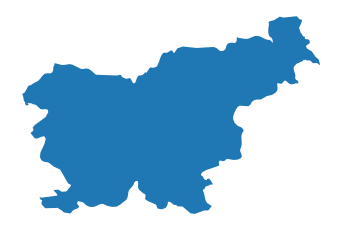

In [3]:
# Folder where data for running the notebook is located
DATA_FOLDER = os.path.join('.', 'example_data')

# Folder where data will be stored
EOPATCH_FOLDER = os.path.join('.', 'eopatches', 'eopatches')
EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
RESULTS_FOLDER = os.path.join('.', 'results')
os.makedirs(EOPATCH_FOLDER, exist_ok=True)
os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)
os.makedirs(RESULTS_FOLDER, exist_ok=True)

#country = gpd.read_file(os.path.join(DATA_FOLDER, 'ukraine.geojson'))
countries = gpd.read_file('data.gpkg')
country = countries[countries.SOVEREIGNT.str.contains('Slovenia')]
# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N

if country.crs != country_crs:
    country = country.to_crs(crs=country_crs.pyproj_crs())

country_shape = country.geometry.tolist()[-1]
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))

bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

# Plot country
country.plot()
plt.axis('off');


In [4]:

ID = 100
# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = 'ukraine_500x500.gpkg'
gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver='GPKG')

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


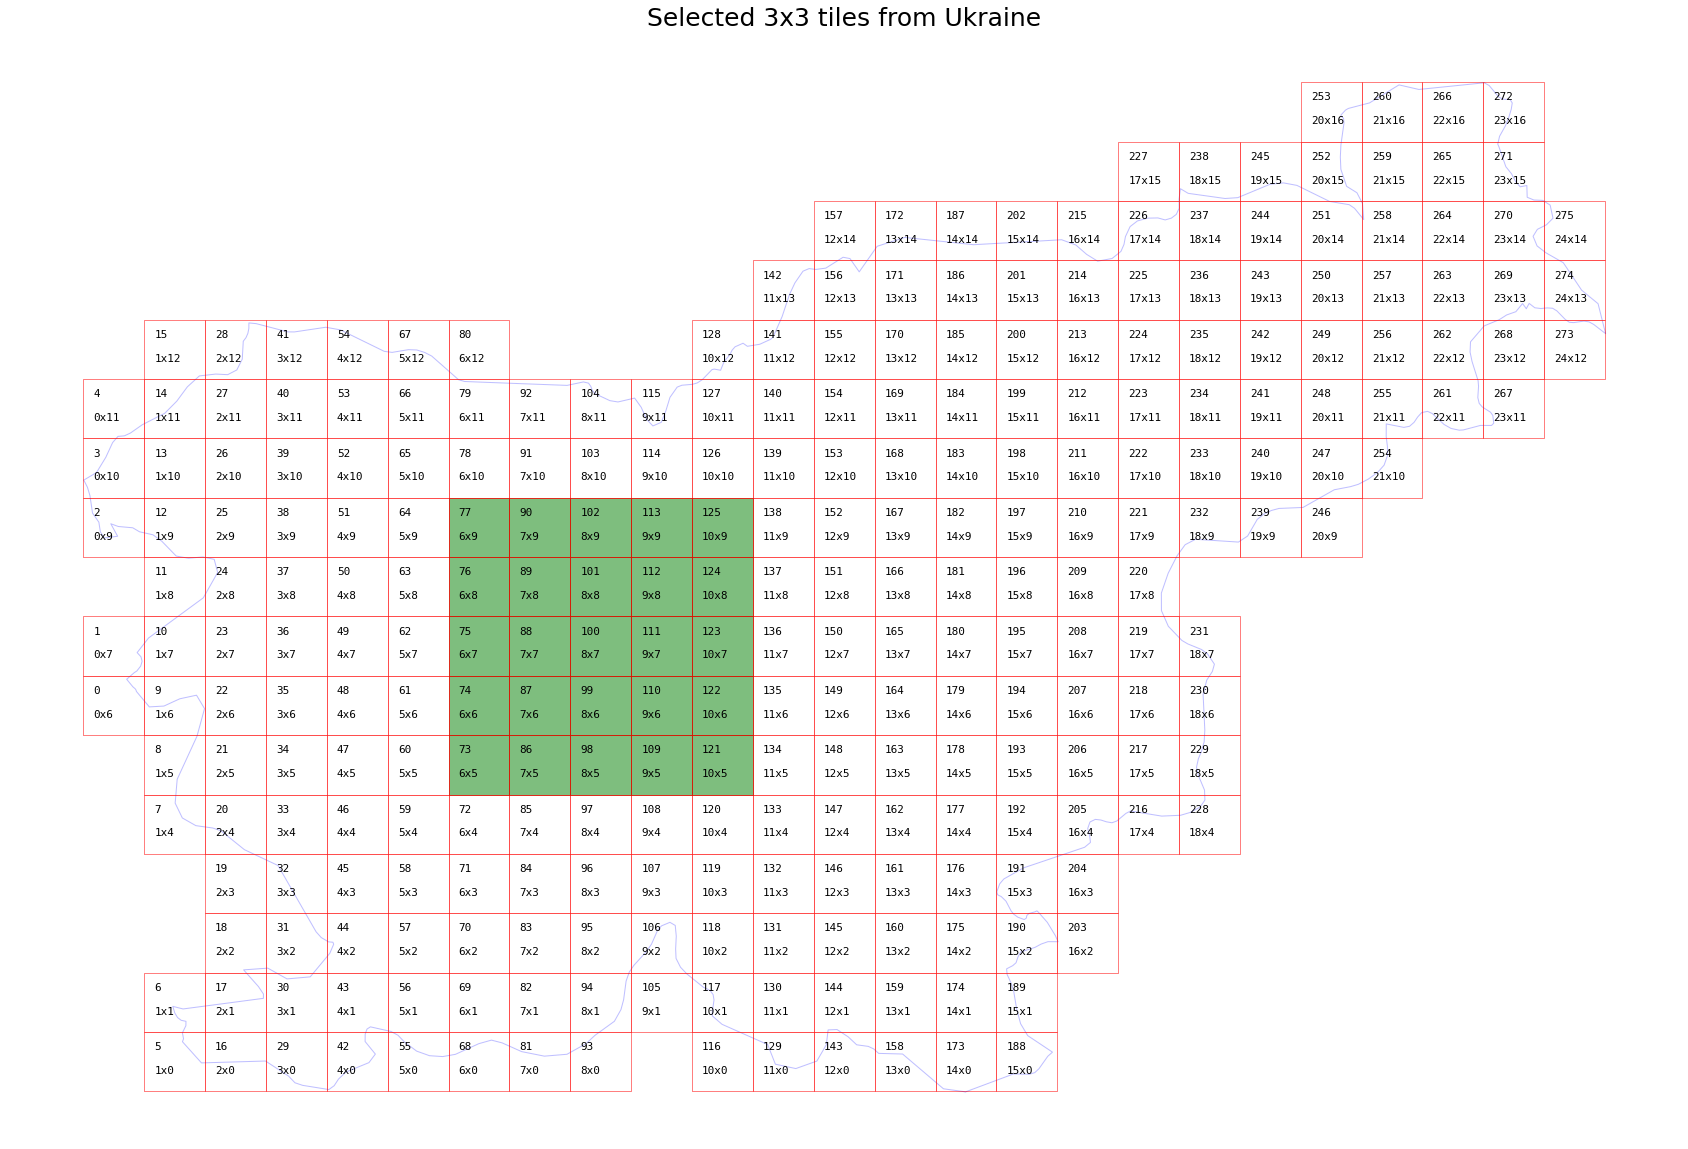

In [5]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# Display bboxes over country
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title('Selected 3x3 tiles from Ukraine', fontsize=25)
country.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5)
gdf.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5)

for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

# Mark bboxes of selected area
gdf[gdf.index.isin(patchIDs)].plot(ax=ax, facecolor='g', edgecolor='r', alpha=0.5)

plt.axis('off');

In [10]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

In [7]:
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5,
    config=config
)

# ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
# ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
# norm = EuclideanNorm('NORM','BANDS')



ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [8]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [9]:
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
vector_feature = FeatureType.VECTOR_TIMELESS, 'LULC_REFERENCE'

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRaster(
    vector_feature,
    (FeatureType.MASK_TIMELESS, 'LULC'),
    values_column='lulcid',
    raster_shape=(FeatureType.MASK, 'IS_DATA'),
    raster_dtype=np.uint8
)

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    ndvi,
    ndwi,
    ndbi,
    add_sh_validmask,
    add_valid_count,
    vector_import_task,
    rasterization_task,
    save
)

In [ ]:
%%time

# Time interval for the SH request
time_interval = ['2019-01-01', '2019-12-31']

# Define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data: {'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

In [11]:
# Load sampled eopatches
sampled_eopatches = []
for i in range(len(patchIDs)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f'eopatch_{i}')
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [41]:
sampled_eopatches[0].data['FEATURES'][2,188,193]

array([ 0.08247143,  0.06792857,  0.03934286,  0.29857144,  0.13954285,
        0.05338571,  0.76704597, -0.62921709, -0.36308649])

In [28]:
sampled_eopatches[0].mask_timeless['LULC_ERODED'][188,193,0]

0

In [45]:
sampled_eopatches[0].mask_timeless['LULC_ERODED'].shape[0]

189

In [30]:
sampled_eopatches[0]

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(4, 189, 194, 9), dtype=float64)
    FEATURES_SAMPLED: FeatureIO(/data/FEATURES_SAMPLED.npy)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: FeatureIO(/mask_timeless/LULC.npy)
    LULC_ERODED: numpy.ndarray(shape=(189, 194, 1), dtype=uint8)
    LULC_ERODED_SAMPLED: FeatureIO(/mask_timeless/LULC_ERODED_SAMPLED.npy)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((383770.1597740601, 5102038.347746289), (385707.6385419984, 5103927.580782217)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2020, 6, 2, 0, 0), ..., datetime.datetime(2020, 7, 17, 0, 0)], length=4
)

In [47]:
width, height = sampled_eopatches[0].mask_timeless['LULC'].squeeze().shape

In [53]:
def neighbours(im, x, y, nx=1, ny=1):
    return im[max(x-nx, 0):min(x+nx+1, im.mask_timeless['LULC'].squeeze().shape[0]), max(y-ny, 0):min(y+ny+1, im.mask_timeless['LULC'].squeeze().shape[1])]

In [59]:
neighbours(sampled_eopatches[0], 11, 11)

ValueError: slice(10, 13, None) is not a valid FeatureType

In [ ]:
def neighbours(posx,posy,maxx,maxy):
    for posi in range(posx-1, posx+2):
        for posj in range (posy-1, posy+2):
            #print(posi, posj)
            if posi in range(maxx) and posj in range(maxy):
                print(posi, posj)

In [ ]:
for i in range(width):
    for j in range(height):
        neighbours(i,j,width,height)